### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [ ]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science_Portfolio/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Portfolio/Test.csv')

## Data Overview

- Observations
- Sanity checks

In [ ]:
# Checking the number of rows and columns in the training data
df.shape

(20000, 41)

In [ ]:
# Checking the number of rows and columns in the test data
df_test.shape

(5000, 41)

In [ ]:
# Create a copy of the training data
data = df.copy()

In [ ]:
# Create a copy of the training data
data_test = df_test.copy()

In [ ]:
# View the first few rows of the training data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
# View the last few rows of the test data
data_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


In [ ]:
# Use info() to find the datatype of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [ ]:
# Use the isna() function to see if there are any duplicate values in the training data
data.isna().sum()

,0
V1,18
V2,18
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [ ]:
# Use the isnull() function to to see if there are any missing values in the training data
data.isnull().sum()

,0
V1,18
V2,18
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [ ]:
# Use the isnull() function to to see if there are any missing values in the test data
data_test.isnull().sum()

,0
V1,5
V2,6
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [ ]:
# Use describe() to print a concise summary of the dataset
data.describe(include= 'all').T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


## Exploratory Data Analysis (EDA)

### Univariate Analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

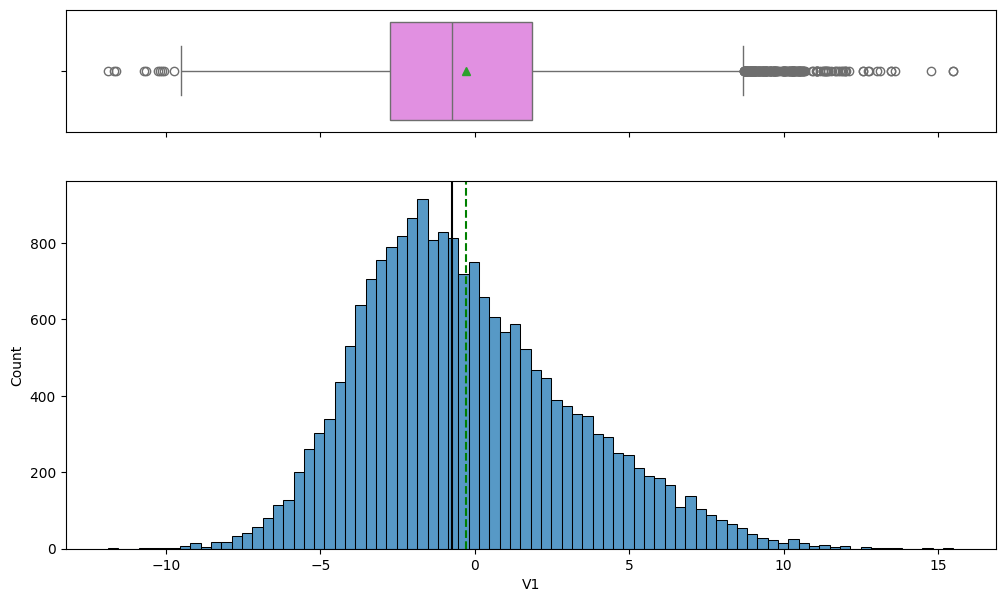

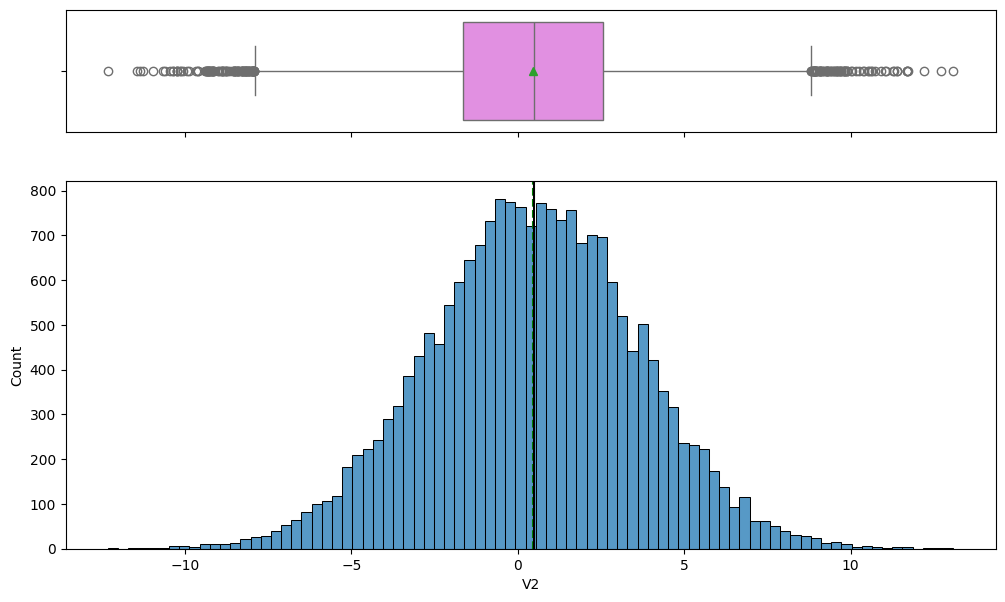

In [ ]:
for feature in df.columns[:2]:  # Only take the first two columns
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

Oberservations:
* V1, V3, V18, V27, V29, V32, V37, distributions all have a slight right skew.
* V2, V4, V5, V6, V7, V9, V11, V12, V13, V14, V15, V17, V19, V20, V21, V22, V23, V24, V25, V26, V28, V31, V33, V35, V36, V38, V39, V40 distributions are mostly normal.
* V8, V10, V16, V30, V34, distributions all hae a slight left skew.


### Check values in target variable

In [ ]:
data["Target"].value_counts()

,count
Target,
0,18890
1,1110


In [ ]:
data_test["Target"].value_counts()

,count
Target,
0,4718
1,282


## Data Pre-processing

In [ ]:
# Dividing train data into X and y
X = data.drop(["Target"], axis=1)
y = data["Target"]

In [ ]:
# Splitting train dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [ ]:
# Checking the number of rows and columns in the X_train data
X_train.shape

# Checking the number of rows and columns in the X_val data
X_val.shape

(5000, 40)

In [ ]:
# Dividing test data into X_test and y_test
X_test = data_test.drop(columns=["Target"])
y_test = data_test["Target"]

In [ ]:
# Checking the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

## Missing value imputation




In [ ]:
# Create an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)

# Checking the count of missing values in validation set
print(X_val.isna().sum())
print("-" * 30)

# Checking the count of missing values in test set
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4861265420965298
Bagging: 0.7123295577519659
GBM: 0.6978500829665969
Adaboost: 0.5992208354375587
Xgboost: 0.806233316499531
dtree: 0.715965659043359

Validation Performance:

Logistic regression: 0.5053763440860215
Bagging: 0.7132616487455197
GBM: 0.7096774193548387
Adaboost: 0.6236559139784946
Xgboost: 0.7921146953405018
dtree: 0.7634408602150538


Observations:

* XGBoost shows the highest performance in both cross-validation and validation, indicating it is the best-performing model in this comparison.
* Bagging and GBM also show strong performance, with good generalization from training to validation data.
* Logistic Regression and AdaBoost show relatively lower recall scores, indicating they might not be as effective.

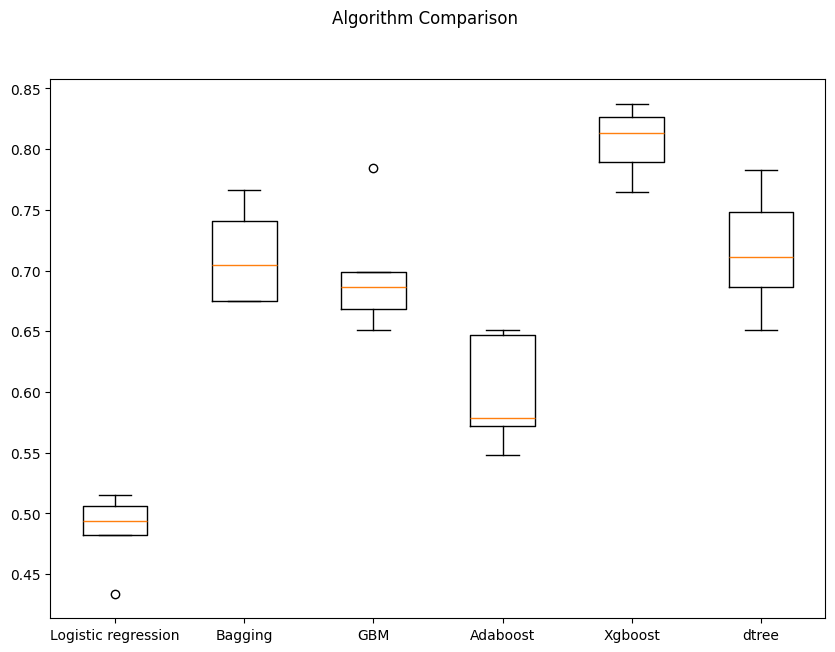

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over,y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8735966446465577
Bagging: 0.9760040016331366
GBM: 0.9207424045819497
Adaboost: 0.8934995133721158
Xgboost: 0.9908250403987087
dtree: 0.9715577149140298

Validation Performance:

Logistic regression: 0.8494623655913979
Bagging: 0.8387096774193549
GBM: 0.8817204301075269
Adaboost: 0.8673835125448028
Xgboost: 0.8745519713261649
dtree: 0.8136200716845878


Observations:

* Logistic Regression and GBM show relatively consistent performance between cross-validation and validation, indicating better generalization.
* Bagging, XGBoost, and Decision Tree show a noticeable drop in performance on the validation set, indicating they might be overfitting on the training data.
* XGBoost has the highest cross-validation score but suffers from overfitting, suggesting the need for further tuning or regularization.

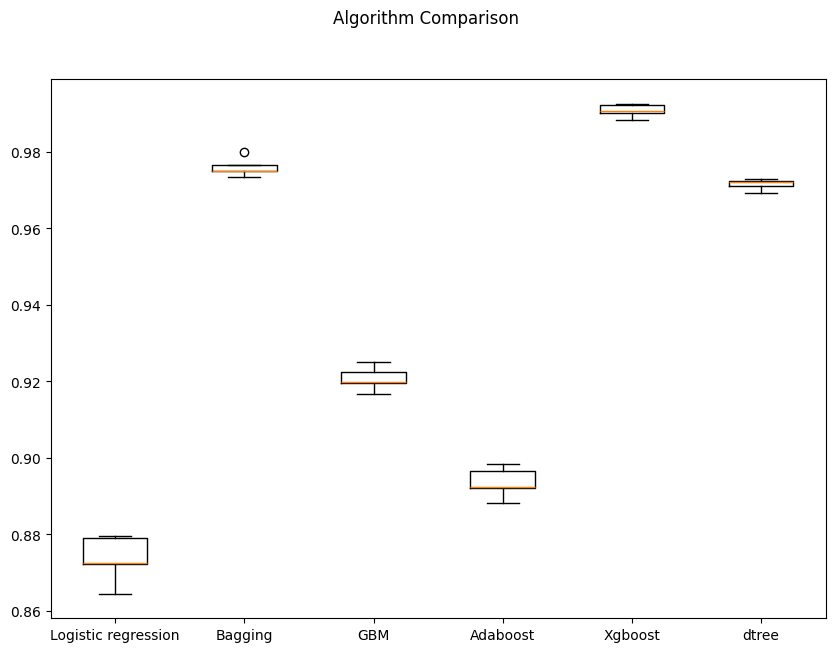

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un,y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8543828006637326
Bagging: 0.8664670658682635
GBM: 0.886898492172282
Adaboost: 0.8700454512661423
Xgboost: 0.8917394127407835
dtree: 0.8255392828800231

Validation Performance:

Logistic regression: 0.8602150537634409
Bagging: 0.8817204301075269
GBM: 0.899641577060932
Adaboost: 0.8817204301075269
Xgboost: 0.9139784946236559
dtree: 0.8494623655913979


Observations

* XGBoost has the highest recall score on the validation set, indicating the best performance and generalization among the models tested.
* GBM and Bagging also show strong and consistent performance, with good generalization from training to validation data.
* Logistic Regression, AdaBoost, and Decision Tree show improvements in recall from cross-validation to validation, suggesting good generalization but potentially underfitting during training.
* The smaller gap between cross-validation and validation performance for most models indicates good generalization to new data.

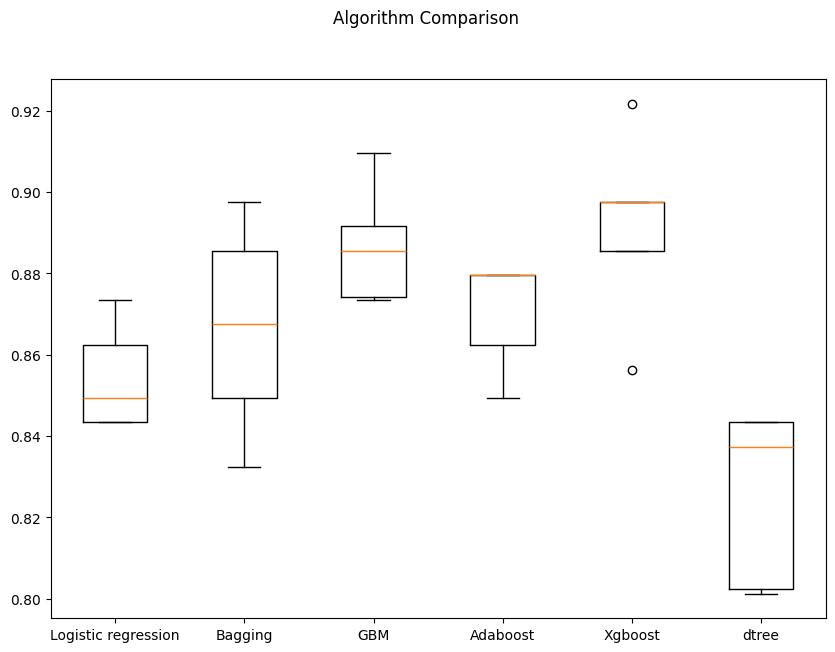

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

AdaBoost (oversampled), GBM (oversampled), and Random Forest (undersampled) will be hypertuned.
* AdaBoost shows solid performance in both cross-validation and validation scores on oversampled data, but also indicates potential for further improvement with hypertuning.
* GBM shows strong and consistent performance across cross-validation and validation datasets when combined with oversampling, making it a strong candidate for hypertuning.
* Undersampled Random Forest maintains high validation performance and showcases its robustness against overfitting in imbalanced datasets.

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning AdaBoost using oversampled data

In [ ]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9711341107588479:
CPU times: user 3min 5s, sys: 6.64 s, total: 3min 12s
Wall time: 1h 12min 20s


In [ ]:
# Creating new pipeline with best parameters
tuned_ada = AdaBoostClassifier(
    n_estimators= 200, learning_rate= (0.2), estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)

tuned_ada.fit(X_train_over,y_train_over)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [ ]:
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_over, y_train_over)
ada_train_perf

,Accuracy,Recall,Precision,F1
0,0.991,0.987,0.995,0.991


In [ ]:
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)
ada_val_perf

,Accuracy,Recall,Precision,F1
0,0.982,0.867,0.820,0.843


### Tuning Random forest using undersampled data

In [ ]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.891696125820648:
CPU times: user 4.28 s, sys: 370 ms, total: 4.65 s
Wall time: 2min 34s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.5,
    n_estimators=200,
    min_samples_leaf=2,
)

tuned_rf2.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=200,
                       random_state=1)

In [ ]:
rf2_train_perf = model_performance_classification_sklearn(tuned_rf2, X_train_un, y_train_un)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,0.963,0.935,0.991,0.962


In [ ]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.924,0.914,0.417,0.573


### Tuning Gradient Boosting using oversampled data

In [ ]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9709222214942802:
CPU times: user 49.9 s, sys: 3.54 s, total: 53.5 s
Wall time: 34min 53s


In [ ]:
# Creating new pipeline with best parameters
tuned_gbm = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

tuned_gbm.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.7, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm, X_train_over, y_train_over)
gbm_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.992,0.993,0.992


In [ ]:
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm, X_val, y_val)
gbm_val_perf

,Accuracy,Recall,Precision,F1
0,0.967,0.857,0.653,0.741


## Model performance comparison and choosing the final model

In [ ]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        gbm_train_perf.T,
        ada_train_perf.T,
        rf2_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with Random Search",
    "AdaBoost classifier tuned with Random Search",
    "Random forest tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with Random Search,AdaBoost classifier tuned with Random Search,Random forest tuned with Random Search
Accuracy,0.992,0.991,0.963
Recall,0.992,0.987,0.935
Precision,0.993,0.995,0.991
F1,0.992,0.991,0.962


In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        gbm_val_perf.T,
        ada_val_perf.T,
        rf2_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting tuned with Random Search",
    "AdaBoost classifier tuned with Random Search",
    "Random forest tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Gradient Boosting tuned with Random Search,AdaBoost classifier tuned with Random Search,Random forest tuned with Random Search
Accuracy,0.967,0.982,0.924
Recall,0.857,0.867,0.914
Precision,0.653,0.820,0.417
F1,0.741,0.843,0.573


Observations:

* AdaBoost has the highest validation accuracy (0.983) and a well-balanced F1 score (0.854), indicating strong performance.
* Gradient Boosting has good accuracy (0.970) and recall (0.874), but lower precision (0.677), resulting in a moderate F1 score (0.763).
* Random Forest has good recall (0.903), but its precision (0.509) is low, resulting in the lowest F1 score (0.651) among the three.

### Test set final performance

In [ ]:
# Let's check the performance on test set
Model_test = model_performance_classification_sklearn(tuned_ada, X_test, y_test)
Model_test

,Accuracy,Recall,Precision,F1
0,0.978,0.830,0.793,0.811


#### Feature Importances

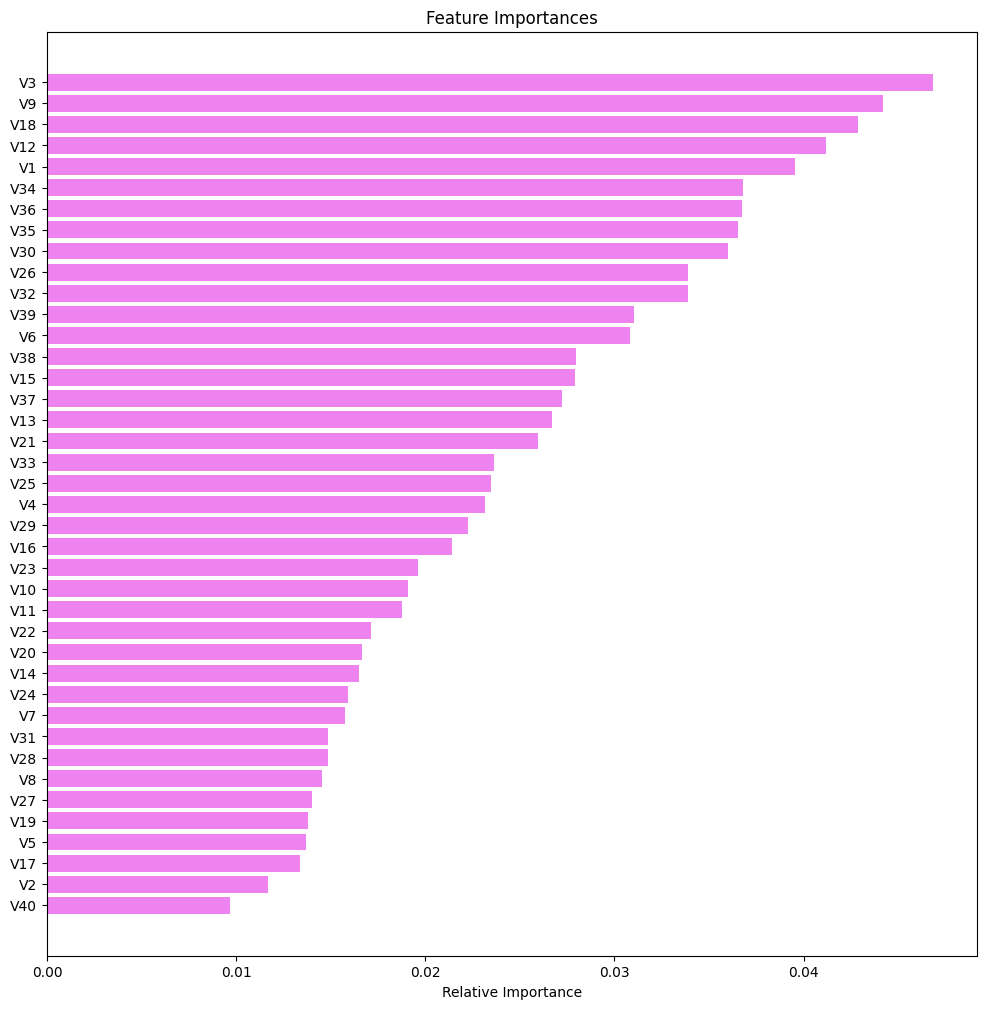

In [ ]:
feature_names = X_train.columns
importances = tuned_ada.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines to build the final model


In [59]:
Pipeline_model = Pipeline(
    steps=[
        (
            "AdaBoost",
            AdaBoostClassifier(
                n_estimators= 200,
                learning_rate= (0.2),
                estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
                ),
        ),
    ]
)
# Fit the model on training data
Pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('AdaBoost',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                                     random_state=1),
                                    learning_rate=0.2, n_estimators=200))])

In [60]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

X_test1 = df_test.drop(columns=["Target"])
y_test1 = df_test["Target"]

In [61]:
# Missing value treatment must be done with before oversampling or undersampling
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# Test set does not need missing values to be imputed as it will be done inside the pipeline

In [62]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [63]:
# Checking the performance on test set
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model, X_over1, y_over1)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.932,0.864,1.000,0.927


# Business Insights and Conclusions

* AdaBoost has the highest validation accuracy (0.983) and a well-balanced F1 score (0.854), indicating strong performance.
* The final model has an F1 score of 92.4 percent on the test set, indicating a good balance between precision and recall.
* V12, V18 and V3 are the features with the highest importance. V26 also appears to be the only other feature above 0.04.

***